In [1]:
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import helper_functions.fitMetrics as fitMetrics
import helper_functions.displayFunctions as display

In [2]:
with open('predictions/saved_predictions.pkl', 'rb') as f:
    results = pickle.load(f)

df = pd.read_csv('data/experiment_boxes.csv')

## Visualizing Box and Segment

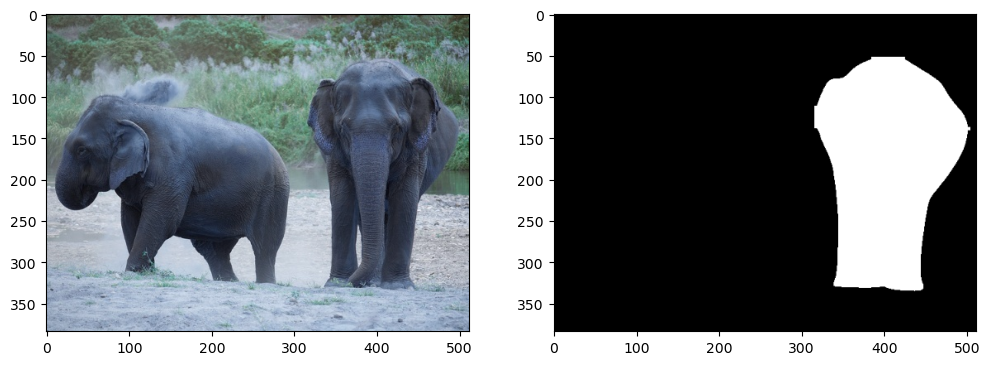

In [3]:
# image_name = 'MIRFLICKR25 - im12013.jpg' # 1 element
image_name = 'COCO - 000000372250.jpg'     # 2 elements
# image_name = 'CAT2000 -195.jpg'            # 0 elements
row_idx = 2

mask = results[image_name].masks[0].data.cpu().numpy()[0]
mask = cv2.resize(mask, (results[image_name].orig_shape[1], results[image_name].orig_shape[0]))

image = cv2.imread('images/images_nat/' + image_name)

df_image = df[df['file_name'] == image_name]
row = df_image.iloc[row_idx]

display.drawBB(image, row)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[1].imshow(mask, cmap='gray')
plt.show()


## Match bounding box with object detection segment

Calculating Intersection Over Union (IOU) and Dice Score.

**Intersection Over Union**
$$\frac{\text{Area of Intersection}}{\text{Area of Polygon} + \text{Area of Mask} - \text{Area of Intersection}}$$

**Dice Score**
$$\text{Dice} = \frac{2 \times \text{Area of Intersection}}{\text{Area of Polygon} + \text{Area of Mask}}$$


In [4]:
def get_od_match_row(row, predictions):
    matches = []
    for i in range(len(predictions[row['file_name']])):
        points = display.getBBPoints(row)
        mask = predictions[row['file_name']].masks[i].data.cpu().numpy()[0]
        mask = cv2.resize(mask, (predictions[row['file_name']].orig_shape[1], predictions[row['file_name']].orig_shape[0]))

        iou = fitMetrics.intersection_over_union(mask, points)
        dice_score = fitMetrics.dice_score(mask, points)
        
        matches.append((i, dice_score, iou))

    if len(matches) == 0:
        matches.append((-1, 0.0, 0.0))

    matches = sorted(matches, key=lambda x: x[2], reverse=True)

    return {
        'match_id': matches[0][0],
        'dice_score': matches[0][1],
        'iou': matches[0][2]
    }

get_od_match_row(row, results)


{'match_id': 0, 'dice_score': 0.0, 'iou': 0.0}

## Match the whole dataset

In [5]:
def get_od_matches(df, predictions):
    box_id = []
    matches = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        if row['file_name'] not in predictions:
            continue

        box_id.append(row['Index'])
        matches.append(get_od_match_row(row, predictions))

    matches = pd.DataFrame(matches)
    matches.insert(0, 'box_id', box_id)

    return matches

od_matches = get_od_matches(df, results)
od_matches.to_csv('data_out/object_detection/box_matches.csv')
od_matches

100%|██████████| 39254/39254 [04:18<00:00, 151.57it/s]


,box_id,match_id,dice_score,iou
0,0,0,0.145687,0.078124
1,1,-1,0.000000,0.000000
2,2,2,0.618767,0.442655
3,3,-1,0.000000,0.000000
4,4,-1,0.000000,0.000000
...,...,...,...,...
39249,39249,0,0.069947,0.035430
39250,39250,0,0.866125,0.743869
39251,39251,0,0.000000,0.000000
39252,39252,0,0.000000,0.000000
